In [1]:
import pathlib
import calendar
import datetime as dt
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client

# import matplotlib.pyplot as plt
from transformers import TypeRecast
from sklearn.pipeline import make_pipeline
from dask_ml.decomposition import PCA

data_folder = pathlib.Path('data')

In [2]:
client = Client(n_workers=1)
client

2022-05-29 20:50:35,462 - distributed.diskutils - INFO - Found stale lock file and directory '/home/avagadro/projects/gb_megafon/dask-worker-space/worker-ny781c27', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 15.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34741,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.59 GiB
Comm: tcp://127.0.0.1:42913,Total threads: 8
Dashboard: http://127.0.0.1:38699/status,Memory: 15.59 GiB
Nanny: tcp://127.0.0.1:41269,


## prepare data

In [3]:
train = pd.read_csv(data_folder.joinpath('data_train.csv'), index_col='Unnamed: 0')
train.head(2)

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  int64  
 3   target    831653 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 31.7 MB


In [4]:
recaster = make_pipeline(TypeRecast('vas_id', 'int'),
                         TypeRecast('target', 'int'),
                         TypeRecast('buy_time', 'datetime')
                         )

In [5]:
train = pd.read_csv(data_folder.joinpath('data_train.csv'), index_col='Unnamed: 0')
train = recaster.fit_transform(train)
train.head(2)

,id,vas_id,buy_time,target
0,540968,8,2018-09-17,0
1,1454121,4,2018-07-16,0


In [6]:
test = pd.read_csv(data_folder.joinpath('data_test.csv'), index_col='Unnamed: 0')
test = recaster.fit_transform(test)
test.head(2)

,id,vas_id,buy_time
0,3130519,2,2019-01-21
1,2000860,4,2019-01-21


In [8]:
# # save for tableau
# train['buy_time'] = train['buy_time'].apply(lambda val: str(val.date()))
# train.to_csv(data_folder.joinpath('train_prepared.csv'), index=False)

# test['buy_time'] = test['buy_time'].apply(lambda val: str(val.date()))
# test.to_csv(data_folder.joinpath('test_prepared.csv'), index=False)

## Exploratory data analysis

Ниже представлена только программная часть анализа. Графики представлены в дашбордах:
https://public.tableau.com/app/profile/peter3691/viz/megafon

In [53]:
# train users count
print(f"Total users in train: {train['id'].nunique()}")
print(f"Total users in test:  {test['id'].nunique()}")

# unknown users
known_users_count = test['id'].drop_duplicates().isin(train['id'].unique()).sum()
print(f"Number of users from test and not containing in train: {test['id'].nunique() - known_users_count}")

# vas_id difference
diff = set(train['vas_id']) ^ set(test['vas_id'])
print(f"Products train/test difference: {diff if diff else None}")

# total products count
print(f"Total products count: {train['vas_id'].nunique()}")

Total users in train: 806613
Total users in test:  70152
Number of users from test and not containing in train: 65964
Products train/test difference: None
Total products count: 8


In [16]:
# how many services were offered
offers = train.groupby('id')['vas_id'].nunique()

print(f'Min. number of services offered to the client: {offers.min()}')
print(f'Max. number of services offered to the client: {offers.max()}')
print(f'Avg. number of services offered to the client: {offers.mean()}')


Min. number of services offered to the client: 1
Max. number of services offered to the client: 3
Avg. number of services offered to the client: 1.023296177968865


In [17]:
# ratio of the unique offers
offers.value_counts() / offers.size

1    0.976735
2    0.023234
3    0.000031
Name: vas_id, dtype: float64

In [10]:
# count weekdays
train['buy_time'].apply(lambda val: calendar.day_name[val.weekday()]).value_counts()

Monday    831653
Name: buy_time, dtype: int64

In [6]:
# min/max date
mn, mx = train['buy_time'].min(), train['buy_time'].max()
print(f'First date: {mn.date()}', f'Last date:  {mx.date()}', sep='\n')
print(f"Months in data: {train['buy_time'].dt.month.nunique()}")
print(f"Weeks in data: {train['buy_time'].nunique()}")

First date: 2018-07-09
Last date:  2018-12-31
Months in data: 6
Weeks in data: 26


в `buy_time` только понедельники.

Видимо по понедельникам отрабатывает пайплайн аггрегации данных.
Следовательно, изучить данные в разрезе дней недели не выйдет.
Данные представлены только за часть 2018 года и охватывают разброс в 6 месяцев.
Поскольку данные уже аггрегированы по неделям, динамика за месяц может быть смазана, поэтому буду рассматривать динамику по неделям.

In [12]:
# date of first/last sale
first = train.groupby('vas_id')['buy_time'].min()
last = train.groupby('vas_id')['buy_time'].max()
pd.DataFrame([first, last], index=['first', 'last']).T

,first,last
vas_id,,
1,2018-07-09,2018-12-31
2,2018-07-09,2018-12-31
4,2018-07-09,2018-12-31
5,2018-07-09,2018-12-31
6,2018-07-09,2018-12-31
7,2018-08-27,2018-12-31
8,2018-07-09,2018-12-31
9,2018-07-09,2018-12-31


Даты первой и последней продаж совпадают с границами датасета практически для всех услуг

In [13]:
# aggregate offers data
offers = train.sort_values(by='buy_time').groupby(['vas_id', 'id'])['target'].agg(list)

# Max number of offers
print(f'Max number of offers to one user: {offers.apply(len).max()}')

# Double offers analyse
double_offer_mask = offers.apply(len) > 1

# Users whose target has remained
target_remain_mask = offers[double_offer_mask].apply(lambda val: val[0] == val[1])

print(f'Number of users who left their target unchanged: {offers[double_offer_mask][target_remain_mask].size}')
remained = offers[double_offer_mask][target_remain_mask]
pos_mask = remained.apply(lambda val: val[1] == 1)
print(f'    remained 0: {remained[~pos_mask].size}', f'    remained 1: {remained[pos_mask].size}', sep='\n')

# Users whose target has changed
print(f'Number of users who changed their target: {offers[double_offer_mask][~target_remain_mask].size}')
changed = offers[double_offer_mask][~target_remain_mask]
pos_mask = changed.apply(lambda val: val[1] == 1)
print(f'    changed to 0: {changed[~pos_mask].size}', f'    changed to 1: {changed[pos_mask].size}', sep='\n')


Max number of offers to one user: 2
Number of users who left their target unchanged: 43
    remained 0: 4
    remained 1: 39
Number of users who changed their target: 6206
    changed to 0: 2160
    changed to 1: 4046


In [14]:
# # draft to keep actual (last) user choice
# dup_mask = train.sort_values(by='buy_time')[['id', 'vas_id']].duplicated(keep='last')
# train.sort_values(by='buy_time')[~dup_mask]

## features

In [16]:
feats = dd.read_csv(data_folder.joinpath('features.csv'), sep='\t', blocksize='200MB').drop('Unnamed: 0', axis=1)
feats.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [17]:
# testing
feat_keys = client.submit(feats[['id', 'buy_time']].compute, key='compute_headers')
headers = TypeRecast('buy_time', 'datetime').fit_transform(feat_keys.result())

In [8]:
# check for duplicated user-time pairs
print(f"Features data contains only unique id-time pairs: {headers.shape[0] == headers.drop_duplicates().shape[0]}")

Features data contains only unique id-time pairs: True


In [21]:
# check if all users have features
print(f"Number of train users without any features: {train[~train['id'].drop_duplicates().isin(headers['id'].unique())].shape[0]}")
print(f"Number of test  users without any features: {test[~test['id'].drop_duplicates().isin(headers['id'].unique())].shape[0]}")

Number of train users without any features: 0
Number of test  users without any features: 0


In [18]:
# check weekdays in user features data
[calendar.day_name[wd] for wd in headers['buy_time'].dt.weekday.unique()]

['Monday']

In [10]:
# select users with more than one features' set
feats_count = headers.groupby(['id'])['buy_time'].nunique()
print(f'Max count of sets of features for one user: {feats_count.max()}')

Max count of sets of features for one user: 2


In [11]:
# comparing dates in train and features
actual_users = train.loc[train['id'].isin(feats_count.index), 'id'].unique()
users_mask = train['id'].isin(actual_users)
feats_mask = headers['id'].isin(actual_users)

A = train[users_mask].sort_values(by=['id', 'buy_time'])
B = headers[feats_mask].sort_values(by=['id', 'buy_time'])

# merge and compare buy_time in train and features data
merged = A.merge(B, on='id', how='left', suffixes=('_train', '_feat'))
comparison = (merged['buy_time_train'] - merged['buy_time_feat']).apply(lambda val: val.days)

print(f'Purchase date may be greater than feature date: {(comparison > 0).any()}',
      f'Purchase date may be equal to the feature date: {(comparison == 0).any()}',
      f'Purchase date may be less than feature date:    {(comparison < 0).any()}',
      sep='\n')

Purchase date may be greater than feature date: True
Purchase date may be equal to the feature date: True
Purchase date may be less than feature date:    True


Все наборы фичей имеют уникальные пары user-time. Максимальное количество наборов фичей для юзера - `2`. Агрегация, как и в тренировочных данных - по понедельникам. Но дата аггрегации фичей может отличаться от даты покупки в любую сторону.

Если юзерфичи аггрегированы после покупки, то по идее они уже не могли влиять на таргет.

In [12]:
nan_task = client.submit(feats.isnull().any().compute, key='compute_nans')
nans = nan_task.result()
print(f'Columns containing NaN: {nans[nans].to_list() if nans.any() else "-"}')

Columns containing NaN: -


In [13]:
# describe features
feat_desc = client.submit(feats.describe().compute, key='describe_features')
feat_desc.result().to_csv(data_folder.joinpath('feat_describe.csv'))

In [ ]:
# # read features description .csv
# feat_desc = pd.read_csv(data_folder.joinpath('feat_describe.csv'), index_col='Unnamed: 0')

In [16]:
# get all duplicated featues
dup_feat = feat_desc.result().T.duplicated(keep=False)
print('Duplicated features:', ', '.join(feat_desc.result().columns[dup_feat].to_list()))

Duplicated features: 75, 81, 85, 139, 203


In [17]:
feat_desc.result()['75']

count    4512528.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: 75, dtype: float64

Присутствуют дублированные нулевые фичи: 75, 81, 85, 139, 203. Их можно удалить.

In [18]:
# MERGE for analyse
merge_train = train.sort_values(by='buy_time')
merge_feats = headers.sort_values(by='buy_time')
merge_feats['check_date'] = merge_feats['buy_time']

merged = pd.merge_asof(merge_train, merge_feats, by='id', on='buy_time',
                    #    direction='backward',
                       direction='nearest',
                       )
merged.info()     # NaN means there is no features for this record

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          831653 non-null  int64         
 1   vas_id      831653 non-null  int64         
 2   buy_time    831653 non-null  datetime64[ns]
 3   target      831653 non-null  int64         
 4   check_date  831653 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3)
memory usage: 38.1 MB


In [19]:
# merge data >= date bound
date_bound = '2018-11-19'
bound = dt.datetime.fromisoformat(date_bound)
date_mask = train['buy_time'] >= bound

# MERGE for analyse
merge_train = train[date_mask].sort_values(by='buy_time')
merge_feats = headers.sort_values(by='buy_time')
merge_feats['check_date'] = merge_feats['buy_time']

merged = pd.merge_asof(merge_train, merge_feats, by='id', on='buy_time',
                       direction='backward',
                     #   direction='nearest',
                       )
merged.info()     # NaN means there is no features for this record

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282183 entries, 0 to 282182
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          282183 non-null  int64         
 1   vas_id      282183 non-null  int64         
 2   buy_time    282183 non-null  datetime64[ns]
 3   target      282183 non-null  int64         
 4   check_date  226627 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3)
memory usage: 12.9 MB


#### correlations

In [51]:
# push pure features data to the cluster
features = client.scatter(feats.drop(['id', 'buy_time'], axis=1))

# recast to dask array with computes sizes
dask_array = client.submit(dd.DataFrame.to_dask_array, features, lengths=True, key='recast_to_dask_array')

In [ ]:
# # features covariance
# cov_task = client.submit(dd.DataFrame.cov, features)
# covariance = client.submit(cov_task.result().compute, key='compute_covariance')
# wait(covariance)
# covariance.result().to_csv(data_folder.joinpath('covariance.csv'))

In [ ]:
# # features correlation
# corr_task = client.submit(dd.DataFrame.corr, feats)
# correlation = client.submit(corr_task.result().compute, key='correlation_compute')
# correlation.result().to_csv(data_folder.joinpath('correlation.csv'))

In [47]:
# corr_df = correlation.result()
corr_df = pd.read_csv(data_folder.joinpath('correlation.csv'), index_col='Unnamed: 0')

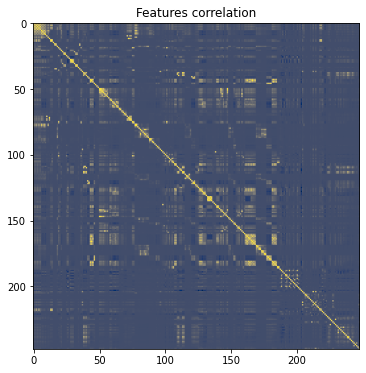

In [49]:
fig = plt.figure(figsize=(6, 6))
plt.title('Features correlation')
plt.imshow(corr_df, cmap='cividis');

Имеется заметное количество признаков с сильной линейной корреляцией

In [52]:
n_components = 5
pca_model = PCA(n_components)
fit_pca = client.submit(pca_model.fit, dask_array, key='fit_pca_model')

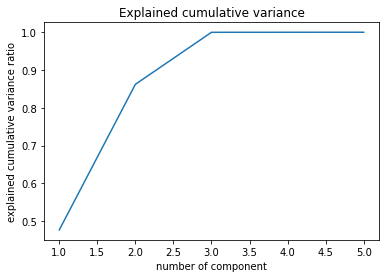

In [83]:
cumulative = fit_pca.result().explained_variance_ratio_.cumsum()
plt.plot(np.arange(n_components) + 1, cumulative)
plt.title('Explained cumulative variance')
plt.xlabel('number of component')
plt.ylabel('explained cumulative variance ratio')
plt.show()

## conclusion

В тренировочных данных наблюдается дисбаланс классов: `7.24%` объектов первого класса.

В подавляющем большинстве (`97.67%`) одному клиенту предлагался один вид услуги; в `2.32%` случаев было предложено два вида услуг; остальным - три.

Услуги 6, 4 и 9 продавались лучше всего: `42,68%`, `25,38%` и `18,35%` от количества их предложений было продано. У остальных услуг доля продаж не превышает `2,6%`.
При этом услуга 9 составляет очень малую долю (`1,67%`) в общем количестве продаж.

До 12-19 ноября основные подключаемые услуги были 4, 6 и 9, при этом услуга 4 постепенно вытесняла услугу 6. Потом доля услуги 4 значительно сократилась, но также значительно выросла доля услуги 6, т.е. произошло обратное замещение. Остальные услуги продавались в незначительно малом количестве. Аналогичная картина с небольшим смещением даты наблюдается в структуре предложения.

Услуга 9 показала необъяснимый всплеск продаж 19 ноября - на два порядка выше медианы. Достоверен ли он - не понять никак.

Присутствуют повторные предложения как с изменением таргета, так и без. Больше двух раз одна и та же услуга никому не предлагалась.

В тестовых данных присутствуют записи только `4188` пользователей, которые были представлены в тренировочных данных, остальные пользователи новые.<br>
Различий по составу продаваемых услуг между тренировочными и тестовыми данными нет. Структура предложения в тестовых данных схожа с таковой для тренировочных данных на период после примерной границы 19 ноября.

Поскольку структура предложения, наблюдаемая в тестовых данных, сформировалась после определенной даты, можно исключить из обучения данные до этой даты - 19 ноября

Пропусков в фичах пользователей нет, но есть нулевые фичи: `75`, `81`, `85`, `139`, `203`.

Дата аггрегации фичей может отличаться от даты покупки в любую сторону, из чего возникает задача сопоставления записи о покупке с фичами пользователя.
1) При сопоставлении тренировочных данных с фичами пользователей по ближайшей дате, независимо от положения на временном отрезке, актуальные фичи присутствуют для всех записей. Данный подход не очень логичен, однако может быть применен в качества базового решения.

2) При сопоставлении по совпадающей дате или ближайшей предшествующей к дате покупки, актуальные фичи получаютя только для 408724 записей, это чуть меньше `50%` всех тренировочных записей. Этот вариант логичнее, поскольку поьзовательский профиль сфрмированый после покупки мог не влиять на решние о покупке, тем более, если он сформирован сильно позже. Т.о. данное решение требует разработки системы заполнения профилей пользователя __для половины__ тренировочных данных, что сделать достаточно непросто.<br>
Если использовать только часть тренировочных данных после 19 ноября, то актуальные фичи есть для 226627 записей, что составляет ~`80%` всех используемых в обучении записей. В этом случае можно попробовать "восстановить" недостающие, несмотря на то, что 20% отсутсвующих данных это по-прежнему очень много.

Фичи можно сжать до 3-х компонент практически без потери информации

In [ ]:
#